# Importing Libraries

In [5]:
%matplotlib inline

import os
import glob
import requests
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from io import BytesIO
from PIL import Image
from kaggle_datasets import KaggleDatasets
from keras.preprocessing.image import ImageDataGenerator

In [6]:
tf.__version__

'2.4.0'

# Checking for GPU/TPU
For TPU usage in notebook check : [Keras MNIST TPU end-to-end - training, saved model and online inference](https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/01_MNIST_TPU_Keras.ipynb#scrollTo=ZE8dgyPC1_6m)

In [28]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # no TPU found, detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
#     strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
#     strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines
    device_name = tf.test.gpu_device_name()
    if "GPU" not in device_name:
        print("GPU device not found")
    print('Found GPU at: {}'.format(device_name))

if strategy.num_replicas_in_sync < 2:
    print("Less Accelerators Enabled! Please enable more to optimize execution.")
    print("Number of accelerators: ", strategy.num_replicas_in_sync)
else:
    print("Number of accelerators: ", strategy.num_replicas_in_sync)

Found GPU at: /device:GPU:0
Less Accelerators Enabled! Please enable more to optimize execution.
Number of accelerators:  1


# Loading Dataset

In [54]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

base_path = '/kaggle/input/arabic-signature-id/arabic_signature'

# Example code to load images
data = []
labels = []

num_classes = len(folders)

# for preprocessing and resizing
new_width = 200
new_height = 200

folders = sorted(os.listdir(base_path))
num_classes = len(folders)

for i, folder in enumerate(folders):
    folder_path = os.path.join(base_path, folder)
    images = sorted(os.listdir(folder_path))

    for image_name in images:
        image_path = os.path.join(folder_path, image_name)
#         print(image_path)
        image = cv2.imread(image_path)
        # Perform any necessary preprocessing (resizing, normalization, etc.) on the image
        # Convert to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Resize the image
        resized_image = cv2.resize(gray_image, (new_width, new_height))


        # Append the preprocessed image and its label
        data.append(resized_image)
        labels.append(i)  # Label according to the folder index (0 to 69 for 70 folders)

# Convert lists to NumPy arrays
data = np.array(data)
labels = np.array(labels)

# Reshape the data for CNN input (add channel dimension for grayscale)
data = data.reshape(-1, new_width, new_height, 1)

# Convert labels to one-hot encoded format
labels = to_categorical(labels, num_classes=num_classes)

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

Epoch 1/200
43/43 [==============================] - 5s 82ms/step - loss: 4.6162 - accuracy: 0.0515 - val_loss: 69.0707 - val_accuracy: 0.0175
Epoch 2/200
43/43 [==============================] - 3s 76ms/step - loss: 3.2720 - accuracy: 0.2165 - val_loss: 7.3570 - val_accuracy: 0.0700
Epoch 3/200
43/43 [==============================] - 3s 78ms/step - loss: 2.0355 - accuracy: 0.4681 - val_loss: 8.6004 - val_accuracy: 0.0321
Epoch 4/200
43/43 [==============================] - 3s 74ms/step - loss: 1.4074 - accuracy: 0.6546 - val_loss: 6.1134 - val_accuracy: 0.0787
Epoch 5/200
43/43 [==============================] - 3s 75ms/step - loss: 0.7356 - accuracy: 0.8215 - val_loss: 6.0356 - val_accuracy: 0.0671
Epoch 6/200
43/43 [==============================] - 3s 74ms/step - loss: 0.5713 - accuracy: 0.8616 - val_loss: 4.0832 - val_accuracy: 0.1662
Epoch 7/200
43/43 [==============================] - 3s 75ms/step - loss: 0.3605 - accuracy: 0.9159 - val_loss: 3.2964 - val_accuracy: 0.3440
Epoch

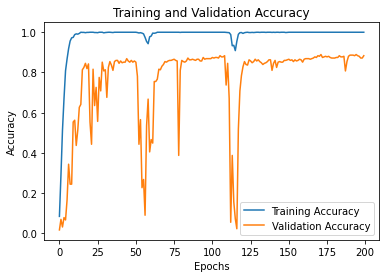

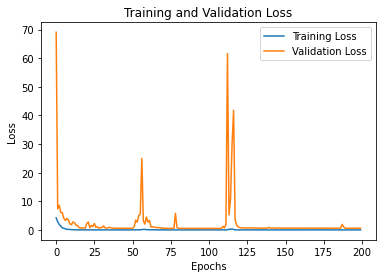

In [57]:
modelRES = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same', input_shape=(200,200,1)),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(70, activation = 'softmax')
])

modelRES.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)


history = modelRES.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val))


# Plotting accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Building Model using ResNet-50

In [58]:
# import tensorflow as tf
# resnet_model = tf.keras.applications.ResNet50(
#     weights='imagenet',
#     include_top=False
# )

# x = resnet_model.output
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dense(512,activation='relu')(x)
# predictions = tf.keras.layers.Dense(
#     70, activation='softmax')(x)

# resnet50_model = tf.keras.models.Model(
#     inputs= resnet_model.input, 
#     outputs=predictions
# )

# resnet50_model.compile(
#     loss='categorical_crossentropy', 
#     optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9),
#     metrics=['accuracy']
# )

# resnet_history = resnet50_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val))

# # Plotting accuracy
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.legend()
# plt.show()

# # Plotting loss
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()
# plt.show()

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- [Errno -3] Temporary failure in name resolution

In [18]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.utils import np_utils
from keras.optimizers import SGD

In [24]:
# Import InceptionV3 Model
inc_model = InceptionV3(weights='../input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False,
                        input_shape=(200,200,3))

print("number of layers:", len(inc_model.layers))
#inc_model.summary()

number of layers: 311


In [43]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

base_path = '/kaggle/input/arabic-signature-id/arabic_signature'

# Example code to load images
data = []
labels = []

num_classes = len(folders)

# for preprocessing and resizing
new_width = 200
new_height = 200

folders = sorted(os.listdir(base_path))
num_classes = len(folders)

for i, folder in enumerate(folders):
    folder_path = os.path.join(base_path, folder)
    images = sorted(os.listdir(folder_path))

    for image_name in images:
        image_path = os.path.join(folder_path, image_name)
#         print(image_path)
        image = cv2.imread(image_path)
        # Perform any necessary preprocessing (resizing, normalization, etc.) on the image
        # Convert to grayscale
#         gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Resize the image
        resized_image = cv2.resize(image, (new_width, new_height))


        # Append the preprocessed image and its label
        data.append(resized_image)
        labels.append(i)  # Label according to the folder index (0 to 69 for 70 folders)

# Convert lists to NumPy arrays
data = np.array(data)
labels = np.array(labels)

# Reshape the data for CNN input (add channel dimension for grayscale)
data = data.reshape(-1, new_width, new_height, 3)

# Convert labels to one-hot encoded format
labels = to_categorical(labels, num_classes=num_classes)

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.3, random_state=42)

In [45]:
#Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(70, activation="softmax")(x)

In [47]:
# creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:52]:
    layer.trainable = False

# compile the model
model_.compile(optimizer=SGD(lr=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

Epoch 1/50
19/19 [==============================] - 13s 329ms/step - loss: 4.4065 - accuracy: 0.0126 - val_loss: 4.3925 - val_accuracy: 0.0156
Epoch 2/50
19/19 [==============================] - 4s 198ms/step - loss: 4.4022 - accuracy: 0.0134 - val_loss: 4.3718 - val_accuracy: 0.0136
Epoch 3/50
19/19 [==============================] - 4s 200ms/step - loss: 4.3373 - accuracy: 0.0219 - val_loss: 4.3101 - val_accuracy: 0.0233
Epoch 4/50
19/19 [==============================] - 4s 200ms/step - loss: 4.2914 - accuracy: 0.0207 - val_loss: 4.3159 - val_accuracy: 0.0253
Epoch 5/50
19/19 [==============================] - 4s 203ms/step - loss: 4.2577 - accuracy: 0.0256 - val_loss: 4.3183 - val_accuracy: 0.0078
Epoch 6/50
19/19 [==============================] - 4s 197ms/step - loss: 4.2193 - accuracy: 0.0374 - val_loss: 4.2957 - val_accuracy: 0.0117
Epoch 7/50
19/19 [==============================] - 4s 197ms/step - loss: 4.1619 - accuracy: 0.0501 - val_loss: 4.2773 - val_accuracy: 0.0175
Epoch

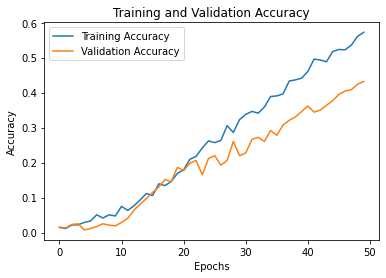

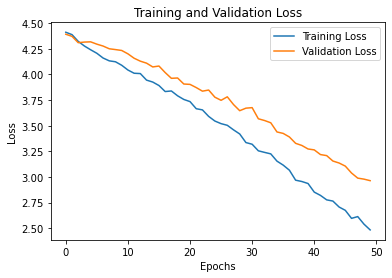

In [48]:
history = model_.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

# Plotting accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [49]:
#Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.7)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(70, activation="softmax")(x)

# creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:52]:
    layer.trainable = False

# compile the model
model_.compile(optimizer=SGD(lr=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])


Epoch 1/100
19/19 [==============================] - 11s 290ms/step - loss: 4.5561 - accuracy: 0.0194 - val_loss: 4.2729 - val_accuracy: 0.0175
Epoch 2/100
19/19 [==============================] - 4s 196ms/step - loss: 4.5274 - accuracy: 0.0169 - val_loss: 4.2408 - val_accuracy: 0.0156
Epoch 3/100
19/19 [==============================] - 4s 203ms/step - loss: 4.4513 - accuracy: 0.0157 - val_loss: 4.2452 - val_accuracy: 0.0195
Epoch 4/100
19/19 [==============================] - 4s 196ms/step - loss: 4.4517 - accuracy: 0.0172 - val_loss: 4.2260 - val_accuracy: 0.0214
Epoch 5/100
19/19 [==============================] - 4s 204ms/step - loss: 4.4579 - accuracy: 0.0219 - val_loss: 4.2342 - val_accuracy: 0.0233
Epoch 6/100
19/19 [==============================] - 4s 206ms/step - loss: 4.3954 - accuracy: 0.0221 - val_loss: 4.2193 - val_accuracy: 0.0311
Epoch 7/100
19/19 [==============================] - 4s 206ms/step - loss: 4.3456 - accuracy: 0.0179 - val_loss: 4.1878 - val_accuracy: 0.037

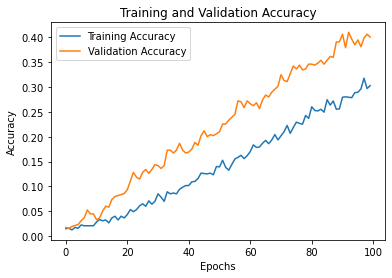

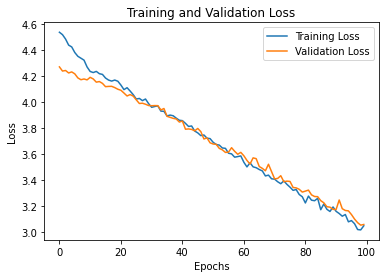

In [50]:
history = model_.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val))

# Plotting accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [51]:
#Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(70, activation="softmax")(x)

# creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:52]:
    layer.trainable = False

# compile the model
model_.compile(optimizer=SGD(lr=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])


Epoch 1/100
19/19 [==============================] - 11s 288ms/step - loss: 4.5045 - accuracy: 0.0189 - val_loss: 4.3009 - val_accuracy: 0.0117
Epoch 2/100
19/19 [==============================] - 4s 203ms/step - loss: 4.3900 - accuracy: 0.0251 - val_loss: 4.2011 - val_accuracy: 0.0272
Epoch 3/100
19/19 [==============================] - 4s 199ms/step - loss: 4.2169 - accuracy: 0.0281 - val_loss: 4.1128 - val_accuracy: 0.0370
Epoch 4/100
19/19 [==============================] - 4s 193ms/step - loss: 4.0788 - accuracy: 0.0541 - val_loss: 4.0230 - val_accuracy: 0.0642
Epoch 5/100
19/19 [==============================] - 4s 196ms/step - loss: 4.0345 - accuracy: 0.0611 - val_loss: 3.9529 - val_accuracy: 0.1187
Epoch 6/100
19/19 [==============================] - 4s 197ms/step - loss: 3.8670 - accuracy: 0.0895 - val_loss: 3.9023 - val_accuracy: 0.1362
Epoch 7/100
19/19 [==============================] - 4s 195ms/step - loss: 3.7616 - accuracy: 0.1263 - val_loss: 3.8561 - val_accuracy: 0.147

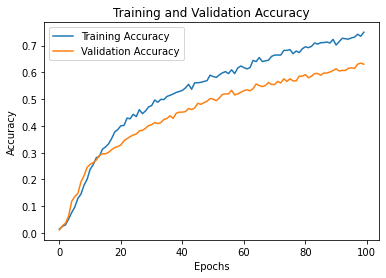

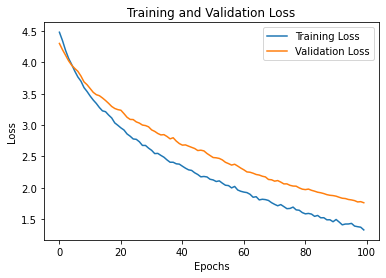

In [52]:
history = model_.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val))

# Plotting accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Epoch 1/200
38/38 [==============================] - 7s 158ms/step - loss: 1.4890 - accuracy: 0.7120 - val_loss: 1.7739 - val_accuracy: 0.6226
Epoch 2/200
38/38 [==============================] - 5s 139ms/step - loss: 1.4570 - accuracy: 0.7187 - val_loss: 1.7138 - val_accuracy: 0.6342
Epoch 3/200
38/38 [==============================] - 5s 140ms/step - loss: 1.4408 - accuracy: 0.7287 - val_loss: 1.6971 - val_accuracy: 0.6420
Epoch 4/200
38/38 [==============================] - 5s 136ms/step - loss: 1.4024 - accuracy: 0.7270 - val_loss: 1.6811 - val_accuracy: 0.6265
Epoch 5/200
38/38 [==============================] - 5s 131ms/step - loss: 1.3919 - accuracy: 0.7270 - val_loss: 1.6549 - val_accuracy: 0.6479
Epoch 6/200
38/38 [==============================] - 5s 130ms/step - loss: 1.3263 - accuracy: 0.7521 - val_loss: 1.6747 - val_accuracy: 0.6342
Epoch 7/200
38/38 [==============================] - 5s 132ms/step - loss: 1.3514 - accuracy: 0.7396 - val_loss: 1.6508 - val_accuracy: 0.6479

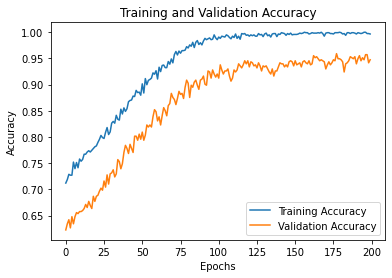

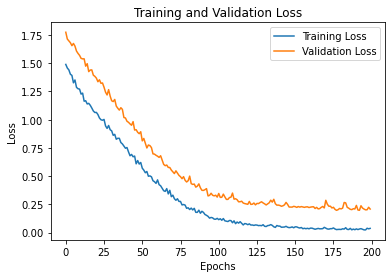

In [53]:
history = model_.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val))

# Plotting accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()